<a href="https://colab.research.google.com/github/GuptaRitik/tweets_SVM_classifier/blob/main/Support_Vector_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u><b> Objective </b></u>
## <b> You are given a data of US Airline tweets and their sentiment. The task is to do sentiment analysis about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). </b>

<br>
<br>

## <b>Things to do :</b>
* ### Read the tweets.csv data, clean and tokenize the tweets using nltk library.
* ### Count vectorize the tweets so that you end up with a sparse matrix (which will be your $X$). 
* ### You are supposed to build a SVM classifier (a binary classification in fact). Since the data contains three levels of sentiment(positive, negative and neutral), you should remove the sentences which are neutral. Once you do that you will have two classes only (positive and negative). You can set the label of positive tweets to 1 and negative tweets to 0.
* ### Once you have built the SVM classifier, evaluate this model across various metrics. Also plot the ROC curve and Precision-Recall curve. Report the areas under these two curves along with other metrics.
* ### Perform GridSearch cross validation for various values of $C$ and $gamma$. These will be the hyperparameters which you would play around with.
* ### Explain your observations and the underlying reasons for these.
* ### Try checking if <code>tfidfvectorizer</code> helps you gain lift in model's performance.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DS_Almabetter /Module 4 - Machine learning/Week-3/SVM/Copy of Tweets.csv')

In [ ]:
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


## as per the problem statement, we are only going to use the text and sentiment column where sentiment is the target column.

In [ ]:
# keeping only 2 columns in dataframe

df = df[['text','airline_sentiment']]

In [ ]:
# checking for nulls


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               14640 non-null  object
 1   airline_sentiment  14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


## Text processing

Tokenizing the text data, to use only important words

In [ ]:
# defing a function to remove punctuation and stop words from text

def nonsense_remover(txt):
  nonstop = ' '.join([i for i in txt.split() if i.lower() not in stopwords.words('english')]) # storing words without stop words
  return ''.join([i for i in nonstop if i not in string.punctuation]) #removing punchuation and retrn the new clean text


In [ ]:
df['clear_text'] = df['text'].apply(nonsense_remover) #applying the function to cleaning text data

In [ ]:
df.drop('text', axis=1, inplace=True) #dropping the old text column

In [ ]:
df.head(8)

,airline_sentiment,clear_text
0,neutral,VirginAmerica dhepburn said
1,positive,VirginAmerica plus added commercials experienc...
2,neutral,VirginAmerica today Must mean need take anothe...
3,negative,VirginAmerica really aggressive blast obnoxiou...
4,negative,VirginAmerica really big bad thing
5,negative,VirginAmerica seriously would pay 30 flight se...
6,positive,VirginAmerica yes nearly every time fly VX “ea...
7,neutral,VirginAmerica Really missed prime opportunity ...


We have to run a binary classifier in this data, so we have to remove "neutral" classificaton from data and keep only positive and negetive as 1 and 0 respectively

In [ ]:
df = df[df['airline_sentiment']!= 'neutral']

In [ ]:
# assigning the 0 and 1 to two classes

df['airline_sentiment'] = df['airline_sentiment'].map({'positive':1, 'negative':0})

## Splitting the train and test data

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df['clear_text'],df['airline_sentiment'],test_size=0.25)

In [ ]:
x_train

4265     united somehow think Im going stuck paying hot...
6062     SouthwestAir Stuck 4251 heat blasting try thaw...
12239    AmericanAir Id love take seat appears though s...
7314     JetBlue less concerned delay notified looked b...
8638         JetBlue WHATS WEBSITE CANT ACCESS FLIGHT INFO
                               ...                        
10920                                 USAirways damn delay
5145     SouthwestAir Disappointed FAA regulation 2 fur...
14245           AmericanAir Im great thanks keep good work
13337    AmericanAir got phone w rep flight disappeared...
12720    AmericanAir company policy refuses employees s...
Name: clear_text, Length: 8655, dtype: object

### Vectorizing the text data

count Vetorizing is used to transform the bag of words in total dat set to each as new column to count the occurance of each word in all sentences, as ML model only learn the numbers.

In [ ]:
vectorizer = CountVectorizer(max_df = 0.9,min_df = 10) #intiating the vectorizor object with some parameters
x_train_vect = vectorizer.fit_transform(x_train)
x_test_vect = vectorizer.transform(x_test)

In [ ]:
x_train_vect

<8655x1259 sparse matrix of type '<class 'numpy.int64'>'
	with 73064 stored elements in Compressed Sparse Row format>

In [ ]:
# created an sparse matrix of words as colum and its counts as values for each row.

x_train_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Fitting the SVM Model

In [ ]:
base_model = SVC(probability=True, random_state=5)  # assigning a model object
base_model.fit(x_train_vect,y_train)  # fitting the model

SVC(probability=True, random_state=5)

In [ ]:
train_pred = base_model.predict(x_train_vect) # predicting train set
test_pred = base_model.predict(x_test_vect)   # predicting test set

In [ ]:
# Train Accuracy score

accuracy_score(y_train, train_pred) 

0.9587521663778162

In [ ]:
# Test Accuracy Score

accuracy_score(y_test,test_pred)

0.9161469161469161

In [ ]:
print('Train Report')
print(classification_report(y_train, train_pred))
print('\n')
print('Test Report')
print(classification_report(y_test, test_pred))

Train Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6895
           1       0.97      0.83      0.89      1760

    accuracy                           0.96      8655
   macro avg       0.96      0.91      0.93      8655
weighted avg       0.96      0.96      0.96      8655



Test Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2283
           1       0.92      0.66      0.77       603

    accuracy                           0.92      2886
   macro avg       0.92      0.82      0.86      2886
weighted avg       0.92      0.92      0.91      2886



In [ ]:
# Predicting the probabilities class 1 and storing it in varible to plot graphs

y_score1 = base_model.predict_proba(x_train_vect)[:,1]
y_score2 = base_model.predict_proba(x_test_vect)[:,1]

## plotting ROC Curve

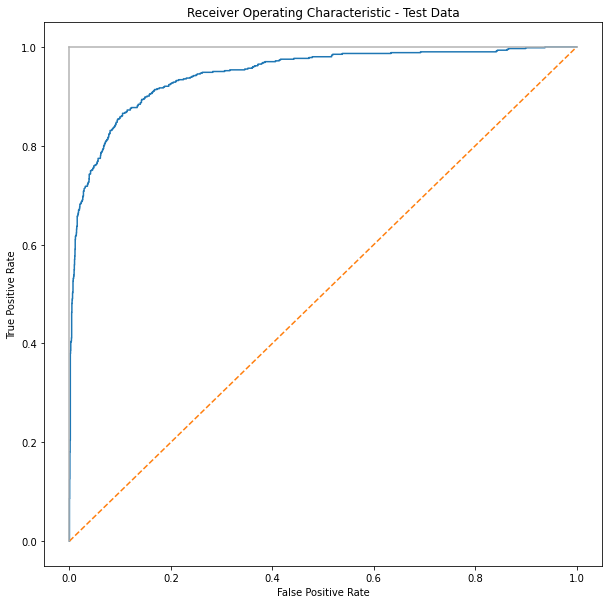

In [ ]:


false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Test Data')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Plotting Precision and Recall Curve

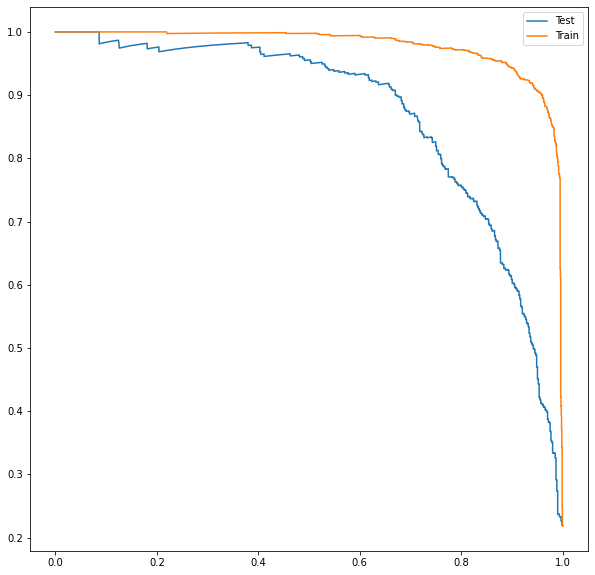

In [ ]:
plt.figure(figsize=(10,10))

#calculate precision and recall

precision, recall, thresholds = precision_recall_curve(y_train, y_score1)
precision2, recall2, thresholds2 = precision_recall_curve(y_test, y_score2)

#create precision recall curve
# fig, ax = plt.subplots()
plt.plot(recall2, precision2)
plt.plot(recall, precision)

#add axis labels to plot
# plt.set_title('Precision-Recall Curve-Test')
# plt.set_ylabel('Precision')
# plt.set_xlabel('Recall')
plt.legend(['Test', 'Train'])

#display plot
plt.show()

## Using Grid Search Cross Validaton for hyperparameter tuning

In [ ]:
# defining parameter range

param_grid = {'C': [0.001, 0.1, 4, 50],
              'gamma': [0.1, 0.01, 0.0001],
              'kernel': ['poly', 'rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, verbose = 3, n_jobs=-1)

# fitting the model for grid search
grid.fit(x_train_vect, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 4, 50], 'gamma': [0.1, 0.01, 0.0001],
                         'kernel': ['poly', 'rbf']},
             verbose=3)

In [ ]:
# Finding Best hyperparameter for model

grid.best_params_

{'C': 4, 'gamma': 0.1, 'kernel': 'rbf'}

In [ ]:
# Calculatng the report of train and test results

grid_train_pred = grid.predict(x_train_vect)
grid_test_pred = grid.predict(x_test_vect)

print(f'Train_accuracy:- {accuracy_score(y_train, grid_train_pred)}')
print(f'Test_accuracy:- {accuracy_score(y_test, grid_test_pred)}')

print('\n')

print('Train Report')
print(classification_report(y_train, grid_train_pred))
print('------------------------------------------------')
print('Test Report')
print(classification_report(y_test, grid_test_pred))

Train_accuracy:- 0.9890236857307915
Test_accuracy:- 0.9168399168399168


Train Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6895
           1       0.99      0.95      0.97      1760

    accuracy                           0.99      8655
   macro avg       0.99      0.98      0.98      8655
weighted avg       0.99      0.99      0.99      8655

------------------------------------------------
Test Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2283
           1       0.86      0.72      0.78       603

    accuracy                           0.92      2886
   macro avg       0.89      0.84      0.87      2886
weighted avg       0.91      0.92      0.91      2886



We see that our Model is improved after using the GridSearhCV method and hyperparameter tuning, its best to tune hyperparametrs to get best performance

# Building model using TF-IDF vectorization

This is also a technique to convert bag of words into column but instead of just word counts TD-IDF is a proper weighting technique to give proper weightage to important words.

In [ ]:
tfvectorizer = TfidfVectorizer(max_df = 0.9,min_df = 10) #intiating the vectorizor object with some parameters
x_train_tf = tfvectorizer.fit_transform(x_train)
x_test_tf = tfvectorizer.transform(x_test)

In [ ]:
tf_model = SVC(random_state=5)  # assigning a model object
tf_model.fit(x_train_vect,y_train)  # fitting the model

SVC(random_state=5)

In [ ]:
tf_train_pred = base_model.predict(x_train_vect) # predicting train set
tf_test_pred = base_model.predict(x_test_vect)   # predicting test set

In [ ]:
print('Train Report')
print(classification_report(y_train, tf_train_pred))
print('------------------------------------------------')
print('Test Report')
print(classification_report(y_test, tf_test_pred))

Train Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6895
           1       0.97      0.83      0.89      1760

    accuracy                           0.96      8655
   macro avg       0.96      0.91      0.93      8655
weighted avg       0.96      0.96      0.96      8655

------------------------------------------------
Test Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2283
           1       0.92      0.66      0.77       603

    accuracy                           0.92      2886
   macro avg       0.92      0.82      0.86      2886
weighted avg       0.92      0.92      0.91      2886



This model is also somewhat improved, there's some changes in Precision and Recall, so we can make optimal decision about which model to choose depend on the stakeholder's preference.